In this lab, you should try to implement some of the techniques discussed in the lecture.
Here is a list of reasonable tasks.
 
Easy:
 * L1 or L2(wybrane) regularization (choose one)
 * momentum(wybrane), Nesterov's momentum (choose one)

Medium difficulty:
 * Adagrad(wybrane, nie dziala), RMSProp (choose one)
 * dropout
 * data augmentation (tiny rotatations, up/down-scalings etc.) (shifts dziala)

Try to test your network to see if these changes improve accuracy. They improve accuracy much more if you increase the layer size, and if you add more layers.

In [2]:
import random
import numpy as np
from torchvision import datasets, transforms

In [20]:
# Let's read the mnist dataset

def load_mnist(path='.'):
    train_set = datasets.MNIST(path, train=True, download=True)
    x_train = train_set.data.numpy()
    _y_train = train_set.targets.numpy()
    
    test_set = datasets.MNIST(path, train=False, download=True)
    x_test = test_set.data.numpy()
    _y_test = test_set.targets.numpy()
    
    x_train = x_train.reshape((x_train.shape[0],28*28)) / 255.
    x_test = x_test.reshape((x_test.shape[0],28*28)) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

In [4]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

In [32]:
class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.G_weights = [np.zeros([y,x]) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.weights_momentum = [np.zeros([y, x]) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.biases_momentum = [np.zeros([y, 1]) for y in sizes[1:]]
        
        self.G_biases = [np.zeros([y, 1]) for y in sizes[1:]]
        

    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a
    
    def update_mini_batch(self, mini_batch, eta, momentum=0, l2=0, adgrad = False):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate      
        nabla_b, nabla_w = self.backprop(x=mini_batch[0].T,y=mini_batch[1].T)
        
        # implementation Adgrad  
        #if adgrad:
        #  eps = 10**(-8)
        #  self.G_weights = [g + w**2 for w, g in zip(nabla_w, self.G_weights) ]
        #  self.weights = [w-(eta/np.sqrt(g + eps ))*nw 
        #                    for w, nw, g in zip(self.weights, nabla_w, self.G_weights)] #list of weights
          
        #  self.G_biases = [g + b**2 for b, g in zip(nabla_b, self.G_biases) ]
        #  self.biases = [b-(eta/np.sqrt(g + eps))*nb 
        #                    for b, nb, g in zip(self.biases, nabla_b, self.G_biases)] #list of biases 
        #  return  
        # momentum for and l2 regularizaction
        self.weights_momentum = [ momentum* w - eta/len(mini_batch[0]) * nw 
                                  for w, nw in zip(self.weights, nabla_w)  ]

        self.weights = [(1-l2)*w+wm for w, wm in zip(self.weights, self.weights_momentum)] #list of weights
        
        # momentum for biases and l2 regularizaction
        self.biases_momentum = [ momentum * b - eta/len(mini_batch[0]) * nb
                                  for b, nb in zip(self.biases, self.biases_momentum)]

        self.biases = [(1-l2)*b+bm for b, bm in zip(self.biases, self.biases_momentum)] #list of biases 

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f) #weighed sum 
            g = sigmoid(f) #activation function
            gs.append(g) #neurons
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y) # last layer
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))): #from last layer to first
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])] # automatic here matmul - matrix product
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)] # CHANGE: Need to sum here
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y) 
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, momentum=0, l2=0, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta=eta, momentum=momentum, l2=l2)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
            else:
                print("Epoch: {0}".format(j))


In [34]:
network = Network([784,30,10])
network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))


Epoch: 0, Accuracy: 0.6219
Epoch: 1, Accuracy: 0.7382
Epoch: 2, Accuracy: 0.7673
Epoch: 3, Accuracy: 0.7812
Epoch: 4, Accuracy: 0.7893
Epoch: 5, Accuracy: 0.7952
Epoch: 6, Accuracy: 0.8004
Epoch: 7, Accuracy: 0.8038
Epoch: 8, Accuracy: 0.8063
Epoch: 9, Accuracy: 0.8084
Epoch: 10, Accuracy: 0.812
Epoch: 11, Accuracy: 0.8137
Epoch: 12, Accuracy: 0.815
Epoch: 13, Accuracy: 0.8166
Epoch: 14, Accuracy: 0.8176
Epoch: 15, Accuracy: 0.8185
Epoch: 16, Accuracy: 0.8195
Epoch: 17, Accuracy: 0.8207
Epoch: 18, Accuracy: 0.8217
Epoch: 19, Accuracy: 0.8222


Momentum:
Accumulate gradients from recent iterations.  Updateparameters like this:
$$
x_{t}= x_{t} + v_{t+1}
$$
with
$$ 
v_t = \gamma v_t - \eta \nabla L(x_t)
$$


In [37]:
from scipy.ndimage.interpolation import shift


def shift_image(image, shiftx, shifty):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [shiftx, shifty], mode="wrap")
    
    return shifted_image.reshape([-1])

def augmented_images(x_train, y_train):
    y_train_new, x_train_new = [], []
    n = len(x_train)

    shiftx = np.random.randint(-3, 3, n)
    shifty = np.random.randint(-3, 3, n)

    for image, label, shiftx, shifty in zip(x_train, y_train, shiftx, shifty):
      x_train_new.append(shift_image(image, shiftx, shifty))
      y_train_new.append(label)

    return (np.array(x_train_new), np.array(y_train_new))



### Augmented images

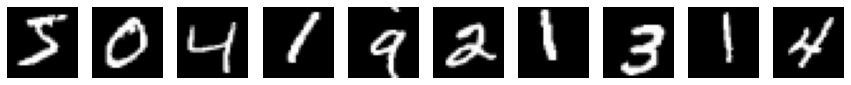

In [41]:
import matplotlib.pyplot as plt

x_shift, y_shift = augmented_images(x_train, y_train)

x_train = np.concatenate([x_train, x_shift])
y_train = np.concatenate([y_train, y_shift])



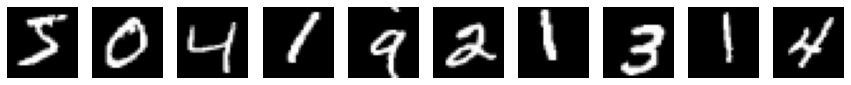

In [42]:
num_samples = 10
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(x_shift[i, :], [28, 28]), cmap='gray')
    s.axis('off')